In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as p
cv2.__version__

'3.4.4'

In [2]:
#paths 

folder = './models'
model_path = os.path.join(folder,'ssd.caffemodel')
proto_path = os.path.join(folder,'deploy.prototxt')

In [3]:
dnet = cv2.dnn.readNetFromCaffe(proto_path,model_path)

In [4]:
# dnet.getLayerNames()

In [5]:
img = cv2.imread('./people/unknown/claire_dearing.jpg')
print(img.shape)
blob_img = cv2.dnn.blobFromImage(img,1.0,size = (300,300),mean = (123.68,116.78,103.94),swapRB = False,crop = False)
blob_img.shape

h,w,_ = img.shape


(370, 640, 3)


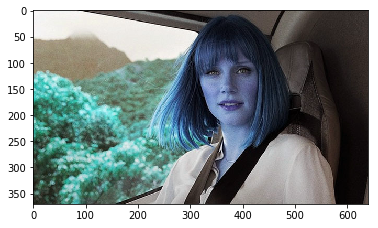

In [6]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 300, 300)


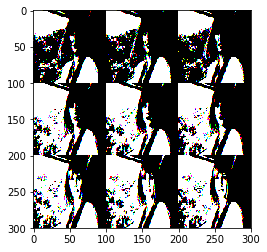

In [7]:
print(blob_img.shape)
plt.imshow(blob_img.reshape(300,300,3))

In [8]:
dnet.setInput(blob_img)
result = dnet.forward()

In [9]:
result[0,0,0]

array([0.        , 1.        , 0.89274985, 0.49845403, 0.1557493 ,
       0.6810177 , 0.57472813], dtype=float32)

In [10]:
finalr = result[0,0,0]

sore = finalr[2]

box = finalr[3:] * np.array([w,h,w,h])
(x1,y1,x2,y2) = box.astype('int32')


print(x1,y1,x2,y2)

cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

319 57 435 212


In [11]:

def iou2(bbox1,bbox2):
    #content of box : x,y,width,height
    #formula  intersection/union
    
    
    x1,y1,w1,h1 = bbox1
    x2,y2,w2,h2 = bbox2
    
#     print(x1,y1,w1,h1)
  
    
    x3 = np.max((x1,x2))
    y3 = np.max((y1,y2))
    w3 = np.min((x1+w1,x2+w2)) - x3
    h3 = np.min((y1+h1,y2+h2)) - y3
    
    #print('w3',w3)
    #print('h3',h3)
    
    if w3<=0 or h3 <=0:
        return 0
    
    iint = w3*h3
    #print(iint)
    u = (w1*h1 + w2*h2) - iint
    #print("area1",w1*h1)
    #print("area2",w2*h2)
    
    return iint/u
 
# print(iou2(box[0],box[1]))
# box


In [12]:

def filter_op(r,conf = 0.9):
    
    
    box = []
    
    #filtering out using confidence levels
    for i in r[0,0,:]:

        if i[2] > conf:
            b = i[3:] * np.array([w,h,w,h])
            box.append(b.astype('int32'))
        
    return box    
        
        
#using nms threshold - 0.5
        
# def iou(box1,box2):
    
#     bx1,by1,bx2,by2 = box1
#     b2x1,b2y1,b2x2,b2y2 = box2
    
#     #print(bx1,by1,bx2,by2)
#     #print(b2x1,b2y1,b2x2,b2y2)
    
#     x = np.maximum(bx1,b2x1)
#     y = np.maximum(by1,b2y1)
    
#     w = np.minimum(bx2,b2x2) - x
#     h = np.minimum(by2,b2y2) - y
    
#     if w<0 and h<0:
#         return 0;
        
    
    
#     intersection = w * h
    
#     union = ((bx2 - bx1) * (by2 - by1) + (b2x2 - b2x1) * (b2y2 - b2y1)) - intersection
    
    
#     return intersection/union
    
    
def nms(box,th = 0.1):   
    
    for p in range(len(box)):
        
        box1 = box[p]
    
        if p == len(box) -1:
#             print('stopping')
            break
    
        for j in range(1,len(box)):
        
            box2 = box[j]
            result = iou2(box1,box2)
#             print('iou',result)
            if result > th:
                box[j] = np.array([0,0,0,0])
#                 print(j)
    return box



In [13]:
def process(res,conf = 0.9,th = 0.1):
    
    
    rect = filter_op(res,conf)
#     print(len(rect))
#     if len(rect)>1:
#         print('perfroming nms')
#         n_rect = nms(rect,th)
#         return [x for x in n_rect if x.all() != 0]
#     else:
    return rect

[array([319,  57, 435, 212], dtype=int32)] 1


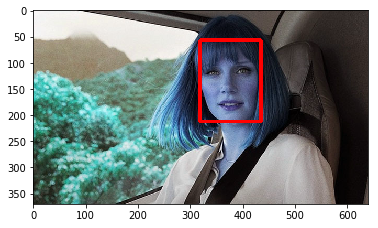

In [14]:
op = process(result,conf = 0.77)
print(op,len(op))

for o in op:
    cv2.rectangle(img,(o[0],o[1]),(o[2],o[3]),(255,0,0),5)
    
plt.imshow(img)

In [15]:
#face net model
enet = cv2.dnn.readNetFromTorch('./models/openface_nn4.small2.v1.t7')

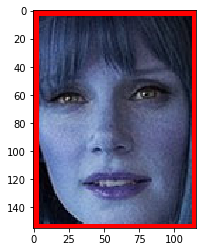

In [16]:
face = img[op[0][1]:op[0][3],op[0][0]:op[0][2]]
# print(face.shape)
face_blob = cv2.dnn.blobFromImage(face,1/255,(96,96),swapRB = True)
# print(face_blob.shape)
plt.imshow(face)

In [17]:
enet.setInput(face_blob)
fresult = enet.forward()

In [18]:
fresult.shape

(1, 128)

In [19]:
def get_embedding(img,r):
    
    face = img[r[1]:r[3],r[0]:r[2]]
#     print(face.shape)
    face_blob = cv2.dnn.blobFromImage(face,1/255,(96,96),swapRB = True)
#     print(face_blob.shape)
    enet.setInput(face_blob)
    return enet.forward()
    
    

CREATING FACE DETECTION PIPELINE Training Phase

In [20]:
#gettiing training images
cam = cv2.VideoCapture(0)
i = 0
name = input('enter name')
while i<20 :

    i = i + 1
    
    _,frame = cam.read()
    
    if not os.path.exists('./people/'+name):
        os.mkdir('./'+name)
        print('folder created')
        
        
    
    img_path = './people/'+name+'/'+name+'_{}'.format(i)+'.jpg'
    cv2.imshow('img',frame)
    cv2.imwrite(img_path,frame)    
    print('image {}/{} saved'.format(i,20))

    
    if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
cam.release()    
cv2.destroyAllWindows()   
        
    
    



KeyboardInterrupt: 

Detecting Faces using model ssd_model

In [ ]:
emb = []
name = []
for path in os.listdir('./people'):
    
    print(path)
    for img in os.listdir('./people/'+path):
        
        
        img_path = './people/'+path+'/'+img
        print(img_path)
        i = cv2.imread(img_path)
        
        
        blob_img = cv2.dnn.blobFromImage(i,1.0,size = (300,300),mean = (123.68,116.78,103.94),swapRB = False,crop = False)
        h,w,_ = i.shape
        dnet.setInput(blob_img)
        result = dnet.forward()
#         print(result.shape)
        res = process(result,conf = 0)
        print('no of detections:',len(res))
#         plt.figure()
#         plt.imshow(i[res[0][1]:res[0][3],res[0][0]:res[0][2]])
#         plt.show()
        emb.append(get_embedding(i,res[0]))
        name.append(path)
        
        
print('no of embeddigs and names',len(emb),len(name))    
with open('./pickle_files/'+'emb.pickle','wb') as f:
    p.dump({'emb':emb,'name':name},f)
        
    

In [21]:
#encoding labels 

from sklearn.preprocessing import LabelEncoder

with open('./pickle_files/emb.pickle','rb') as f:
    data = p.load(f)
    
label  = LabelEncoder()
l = label.fit_transform(data['name'])
print(l)
label.inverse_transform(l)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/home/clive69/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
       'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
       'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
       'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
       'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
       'unknown', 'clive', 'clive', 'clive', 'clive', 'clive', 'clive',
       'clive', 'clive', 'clive', 'clive', 'clive', 'clive', 'clive',
       'clive', 'clive', 'clive', 'clive', 'clive', 'clive', 'clive'],
      dtype='<U7')

In [22]:
from sklearn.svm import SVC

clf = SVC(C = 1.0,kernel = 'linear',probability = True)

clf.fit(np.squeeze(np.array(data['emb'])),l)
# np.squeeze(np.array(data['emb'])).shape,l.shape

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
clf.score(np.squeeze(np.array(data['emb'])),l)

1.0

In [24]:

label.inverse_transform(clf.predict(data['emb'][50]))[0]

/home/clive69/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'clive'

In [25]:
with open('classifier.pickle','wb') as f:
    
    p.dump(clf,f)
 
with open('encoded_label.pickle','wb') as f:
    
    p.dump(label,f)
    
    
    
    

In [ ]:
# def decode(emb):
#     clf = p.load(open('./classifier.pickle','rb'))
#     label = p.load(open('./encoded_label.pickle','rb'))
    
    
    
#     pred = clf.predict(emb)[0]
#     j = np.argmax(pred)
#     print(label.classes_[j])
    
#     return label.classes_[j]
    

Testing :...

In [ ]:
import cv2
#gettiing training images
cam = cv2.VideoCapture(0)
while 1 :

    _,frame = cam.read()
    
    blob_img = cv2.dnn.blobFromImage(frame,1.0,size = (300,300),mean = (123.68,116.78,103.94),swapRB = False,crop = False)
    h,w,_ = frame.shape
    dnet.setInput(blob_img)
    result = dnet.forward()
    print(result.shape)
    res = process(result,conf = 0.9)
    print('no of detections:',len(res))
    
    if len(res) > 0:
        vec  = get_embedding(frame,res[0])
    
#         name = decode(vec)

        name = label.inverse_transform(clf.predict(vec))[0] 
    else:
        print('no detction')
    
    
    for o in res:
        cv2.rectangle(frame,(o[0],o[1]),(o[2],o[3]),(255,0,0),5)
        cv2.putText(frame,name,(o[0],o[1]),cv2.FONT_HERSHEY_SIMPLEX,4,(255,255,255),2,cv2.LINE_AA)

    
    
    cv2.imshow('img',frame)
    

    
    if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
cam.release()    
cv2.destroyAllWindows()   
        
    
    

